<a href="https://colab.research.google.com/github/Jumarti96/Some-projects/blob/main/7_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

from itertools import product
import datetime
from dateutil.relativedelta import relativedelta
import pmdarima as pm
from dateutil.parser import parse

import warnings
warnings.filterwarnings("ignore")

statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.

In [ ]:
#path = 'C:/Users/jesus.gomez/Documents/Turia/Landing/'
path = '/content/drive/MyDrive/Forecasting/Landing/'

df_3filters = pd.read_excel(path + 'data_3_filters.xlsx')
df_3filters.set_index('Month', drop=True, inplace=True)
NA_vars = list(df_3filters.iloc[-1][df_3filters.iloc[-1].isna()].index)
df_3filters.iloc[-1:][NA_vars] = df_3filters.iloc[-4:-1][NA_vars].mean().values

df_3filters = df_3filters.interpolate(method='linear')
df_3filters = df_3filters[df_3filters.index.year >= 2003].copy()

#Algunas variables no tienen valor para el último periodo. Para no contar esos datos, aplicar la siguiente:
#df_3filters = df_3filters.iloc[:-1]

#path = 'C:/Users/jesus.gomez/Documents/Turia/Landing/'
#path = '/content/drive/MyDrive/Forecasting/Landing/'

In [ ]:
df2 = pd.read_excel(path + 'data_granger_less_3filters.xlsx')
df2.set_index('Month', drop=True, inplace=True)

df = df2.copy()

NA_vars = list(df.iloc[-1][df.iloc[-1].isna()].index)
df.iloc[-1:][NA_vars] = df.iloc[-4:-1][NA_vars].mean().values
df = df.interpolate(method='linear')
df = df[df.index.year >= 2003].copy()
df[['PCOPPUSDM', 'PIORECRUSDM', 'Iron_Price_China', 'CPIAUCSL', 'POILWTIUSDM', 'WPU1012']] = df_3filters[['PCOPPUSDM', 'PIORECRUSDM', 'Iron_Price_China', 'CPIAUCSL', 'POILWTIUSDM', 'WPU1012']]
#Algunas variables no tienen valor para el último periodo. Para no contar esos datos, aplicar la siguiente:
#df = df.iloc[:-1]

vars = ['INTDSRUSM193N', 'TTLCONS', 'CCRETT01USM661N', 'PCOPPUSDM', 'PIORECRUSDM', 'CPIAUCSL', 'POILWTIUSDM', 'CPIHOSSL', 'CAPUTLG333S', 'DAUPSA', 'WPU1012', 'IPN3311A2RS']

interventions = ['Covid', 'Aranceles_acero', 'FED_meetings', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']
scrap_vars = ['Scrap_Price', 'scrap_trend', 'scrap_seasonality', 'scrap_resid']
vars_to_share = scrap_vars + vars + interventions
df_to_share = df[vars_to_share]
df = df_to_share.copy()
#df_to_share.to_excel("/content/drive/MyDrive/Forecasting/Landing/data_2_dfs.xlsx")

#path = '/content/drive/MyDrive/Forecasting/Landing/'
#df = pd.read_excel(path + 'data_2_dfs.xlsx')
#df = df.iloc[:-2]
#df.set_index('Month', drop = True, inplace = True)
#df

# df


In [ ]:
seasonal_frequency = 21
future_periods = 3
rolling_periods = 3

fechas_futuras = pd.DataFrame({'date': pd.date_range(start=df.index[-1], periods=future_periods, freq='m')}).set_index('date', drop=True)
df_futuro = df.append(fechas_futuras)

for i in reversed(range(rolling_periods)):
  df_futuro[-i-1:] = df_futuro.shift().rolling(rolling_periods).mean()

df_futuro.iloc[-future_periods:]['scrap_seasonality'] = df_futuro['scrap_seasonality'].shift(seasonal_frequency).values[-future_periods:]
#df_futuro.iloc[-future_periods:][['scrap_resid']] = 1
df_futuro.tail()

In [ ]:
df

## **Dickey Fuller test**

In [ ]:
# Run Augmented Dickey Fuller Test for stationary checking
result = adfuller(df['Scrap_Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value)) # The timeseries for Scrap_Price is not stationary (as expected)
      
df['Delta_Scrap_Price'] = np.log(df['Scrap_Price'])
df['Delta_Scrap_Price'] = df['Delta_Scrap_Price'].diff()

result = adfuller(df['Delta_Scrap_Price'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value)) # The timeseries fordifferentiated Scrap_Price is stationary, so we have to use ARIMA Models
    

ADF Statistic: -3.256137
p-value: 0.016957
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
ADF Statistic: -11.289172
p-value: 0.000000
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


## **Autocorrelation and Partial Autocorrelation**

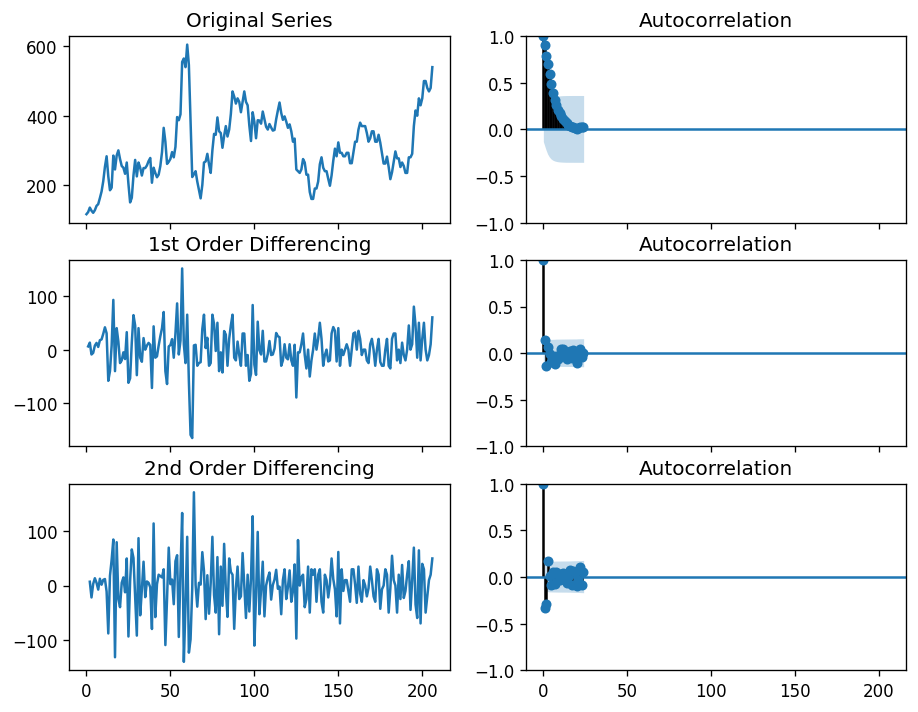

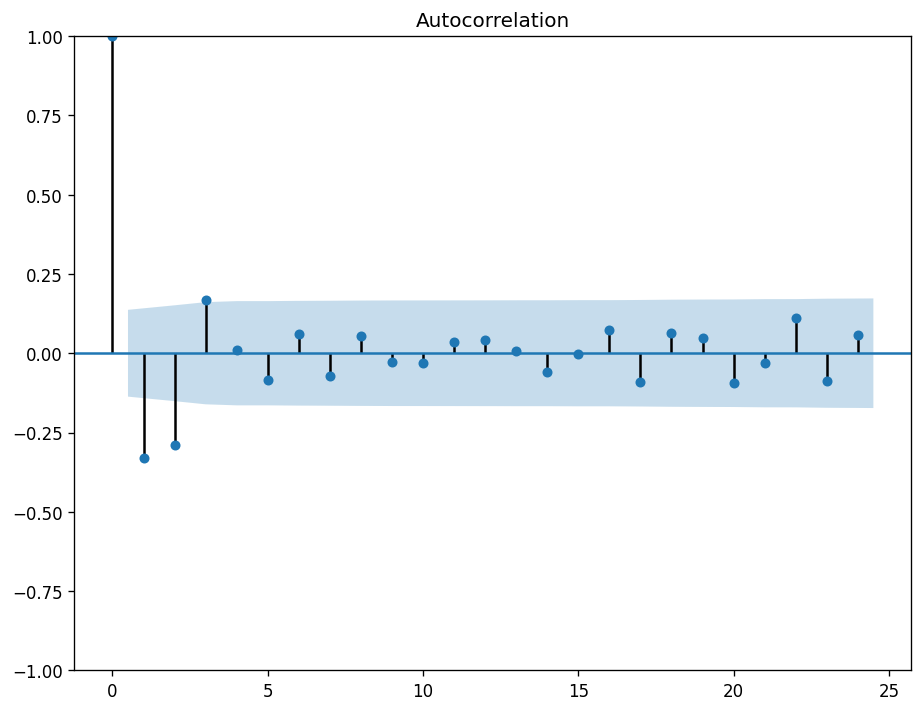

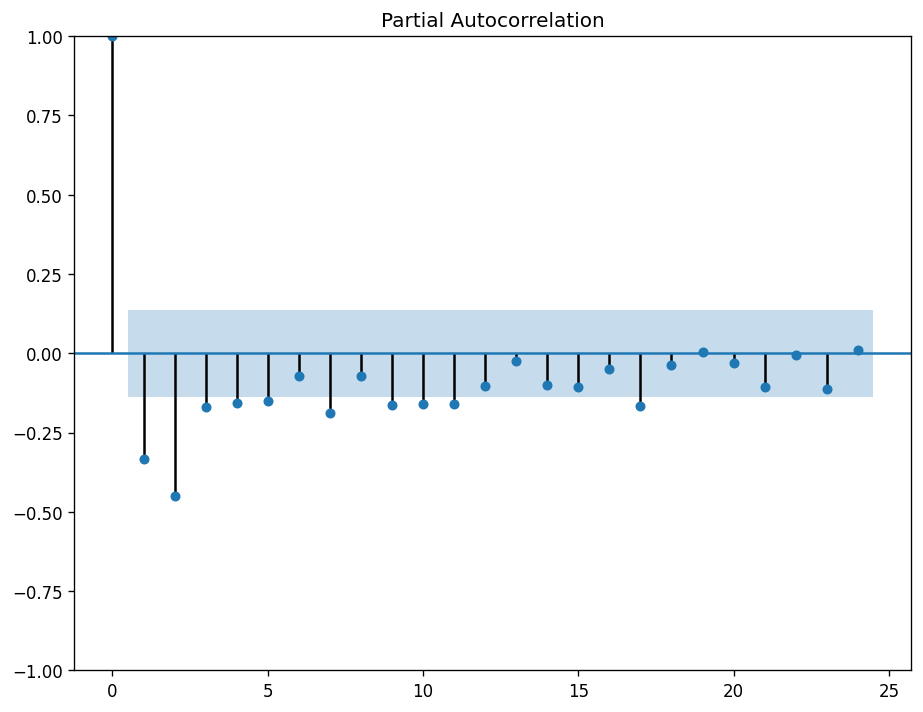

In [ ]:
# Time series data model

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

df['value'] = df['Scrap_Price'].copy()
df = df.reset_index()
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['value']); axes[0, 0].set_title('Original Series')
plot_acf(df['value'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['value'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['value'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['value'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['value'].diff().diff().dropna(), ax=axes[2, 1])

plot_acf(df['value'].diff().diff().dropna())
plot_pacf(df['value'].diff().diff().dropna())
         
plt.show()

df.set_index('Month', inplace=True)

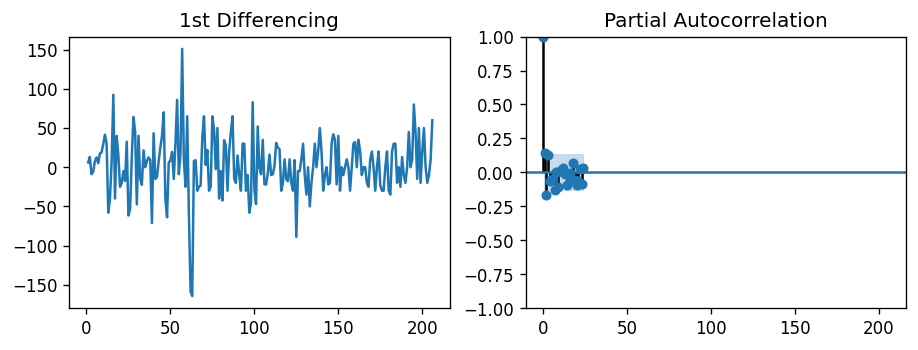

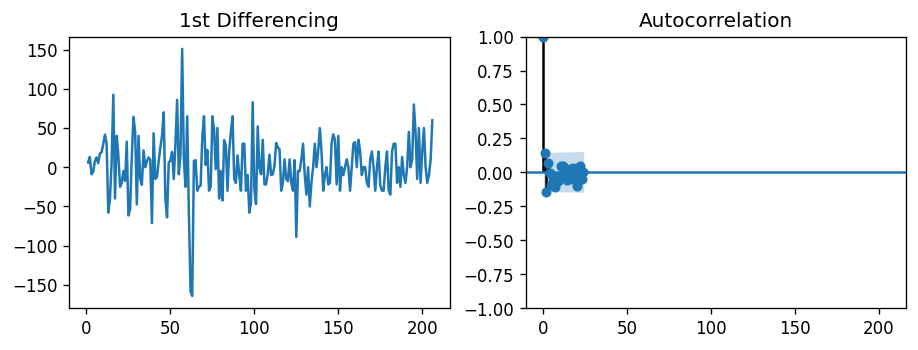

In [ ]:
# PACF plot of 1st differenced series 
# How to find the order of the AR term (p)
df = df.reset_index()
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

# How to find the order of the MA term (q)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

df.set_index('Month', inplace=True)

## **Modelo ARIMA**

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  207
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1033.786
Date:                Thu, 09 Dec 2021   AIC                           2071.572
Time:                        22:06:46   BIC                           2078.218
Sample:                             0   HQIC                          2074.260
                                - 207                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9991      0.387     -2.584      0.010      -1.757      -0.241
sigma2      1370.1045    523.091      2.619      0.009     344.865    2395.344
Ljung-Box (L1) (Q):                   4.23   Jarque-

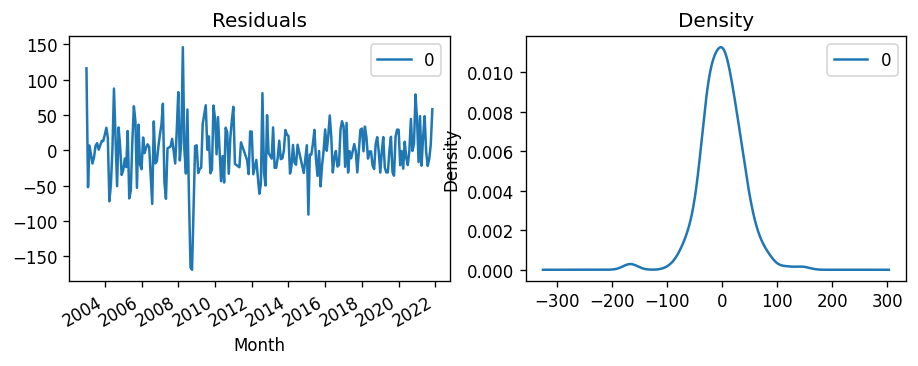

In [ ]:
# 0,2,1 ARIMA Model was chosen by the previous analyses as previous model

model = ARIMA(df.value, order=(0,2,1))
#model_fit = model.fit(disp=0)
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

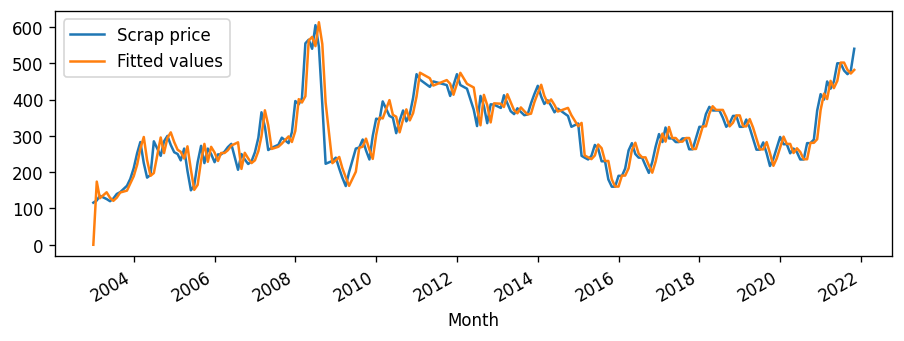

In [ ]:
# Actual vs Fitted
#model_fit.plot_predict(dynamic=False)
#plt.show()

df['Scrap_Price'].plot()
model_fit.fittedvalues.plot()
plt.legend(['Scrap price', 'Fitted values'])
plt.show()


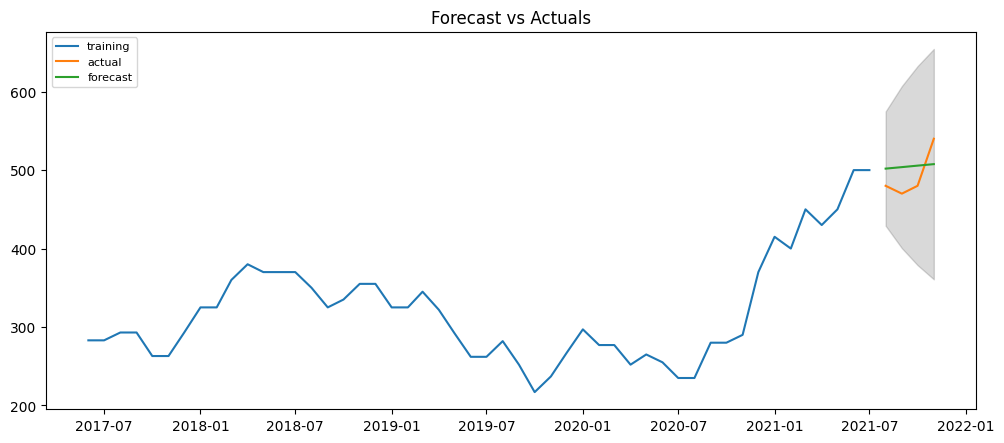

In [ ]:
ns = 4
# Create Training and Test
train = df.value[:-ns]
test = df.value[-ns:]

# Build Model
model = ARIMA(train, order=(0,2,1))  
#fitted = model.fit(disp=-1)  
fitted = model.fit()

# Forecast
#fc, se, conf = fitted.forecast(df.shape[0]-ns, alpha=0.05)  # 95% conf
forecasted = fitted.get_forecast(ns, alpha=0.05).summary_frame()  # 95% conf
forecasted.index = test.index

# Make as pandas series
#fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-50:], label='training')
plt.plot(test, label='actual')
plt.plot(forecasted['mean'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.fill_between(forecasted.index, forecasted['mean_ci_lower'], forecasted['mean_ci_upper'],
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
forecasted

value,mean,mean_se,mean_ci_lower,mean_ci_upper
Month,,,,
2021-08-01,501.904473,37.186245,429.020773,574.788173
2021-09-01,503.808946,52.719529,400.480567,607.137324
2021-10-01,505.713418,64.727099,378.850636,632.576201
2021-11-01,507.617891,74.923720,360.770099,654.465684


In [ ]:

def forecast_accuracy(forecast, actual):
    wape = np.sum(np.abs(forecast - actual))/np.sum(np.abs(actual))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'wape': wape,
            'mape': mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(forecasted['mean'], test.values)

{'acf1': -0.03767279182817549,
 'corr': 0.7661539466182362,
 'mae': 28.452236394006235,
 'mape': 0.0577761837236371,
 'me': 12.261181970031089,
 'minmax': 0.05539052264957456,
 'mpe': 0.027792749605164608,
 'rmse': 28.864474646561224,
 'wape': 0.057771038363464436}

## **Optimización del modelo ARIMA**

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2173.335, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2151.552, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2107.567, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2103.388, Time=0.08 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2105.381, Time=0.19 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.237 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(3, 2, 0)   Log Likelihood               -1047.694
Date:                Thu, 09 Dec 2021   AIC                          

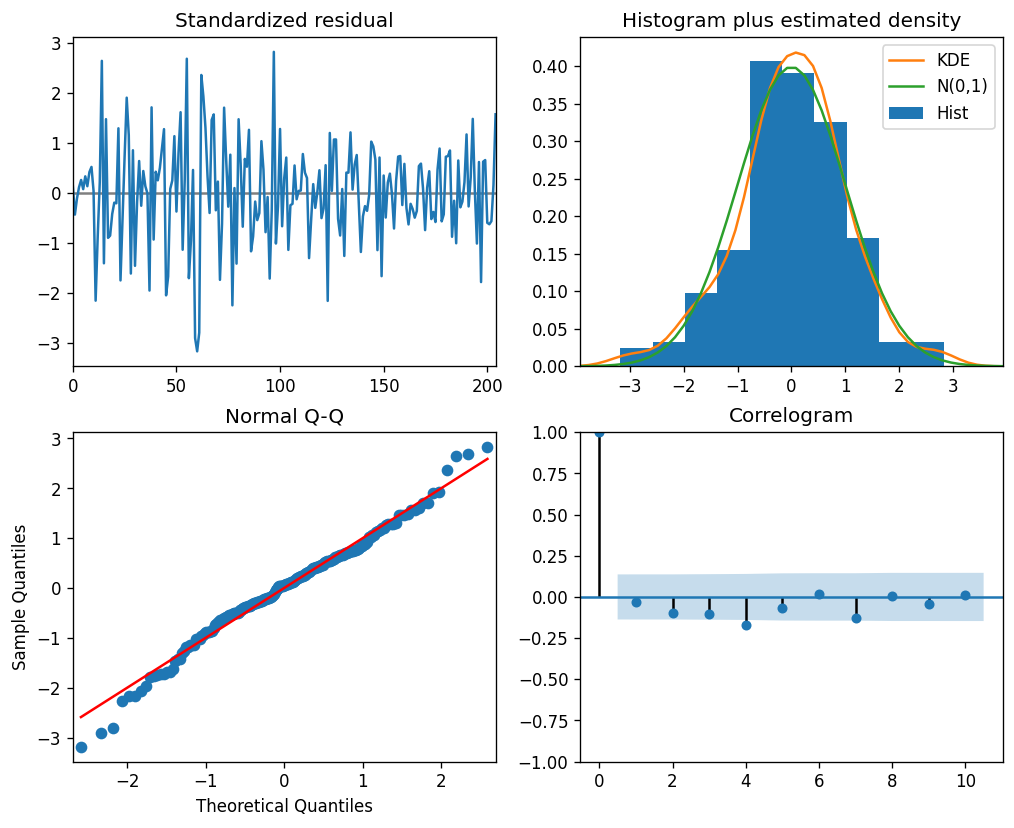

In [ ]:
# ====================== Optimización de ARIMA ==============================

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())  # In this model only the first MA lag is significant

model.plot_diagnostics(figsize=(10,8)) # Standarized Residuals distribution follows a normal standar distribution
plt.show()


In [ ]:
# Forecast
n_periods = 4                                                               # Number of periods to forcast
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=test.index.values)
lower_series = pd.Series(confint[:, 0], index=test.index.values)
upper_series = pd.Series(confint[:, 1], index=test.index.values)

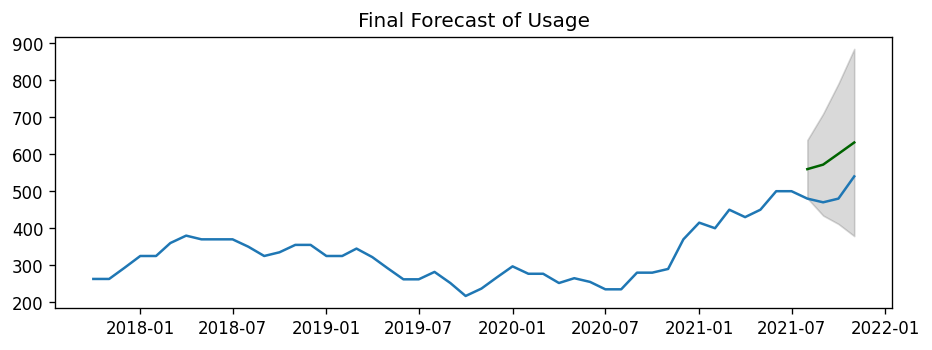

In [ ]:
# Plot
plt.plot(df.value[-50:])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()


## **Modelo SARIMA**

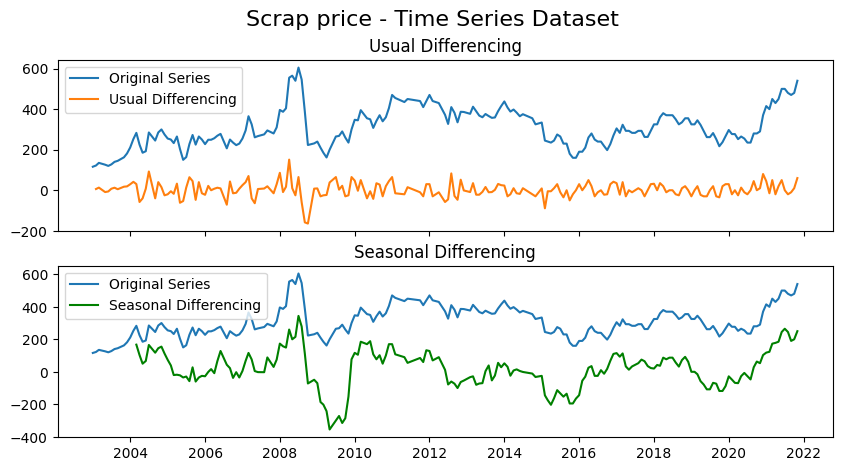

In [ ]:
# Sarima model

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df.value, label='Original Series')
axes[0].plot(df.value.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(df.value, label='Original Series')
axes[1].plot(df.value.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Scrap price - Time Series Dataset', fontsize=16)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[21]             : AIC=inf, Time=4.00 sec
 ARIMA(0,1,0)(0,1,0)[21]             : AIC=2006.031, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[21]             : AIC=1934.418, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[21]             : AIC=inf, Time=2.34 sec
 ARIMA(1,1,0)(0,1,0)[21]             : AIC=2002.581, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[21]             : AIC=1924.175, Time=1.81 sec
 ARIMA(1,1,0)(2,1,1)[21]             : AIC=inf, Time=5.55 sec
 ARIMA(1,1,0)(1,1,1)[21]             : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(2,1,0)[21]             : AIC=1925.687, Time=1.37 sec
 ARIMA(2,1,0)(2,1,0)[21]             : AIC=1924.065, Time=2.18 sec
 ARIMA(2,1,0)(1,1,0)[21]             : AIC=1933.821, Time=0.86 sec
 ARIMA(2,1,0)(2,1,1)[21]             : AIC=inf, Time=6.79 sec
 ARIMA(2,1,0)(1,1,1)[21]             : AIC=inf, Time=2.52 sec
 ARIMA(3,1,0)(2,1,0)[21]             : AIC=1924.375, Time=2.98 sec
 ARIMA(2,1,1)(2,1,0)[21]             : AIC=1923.6

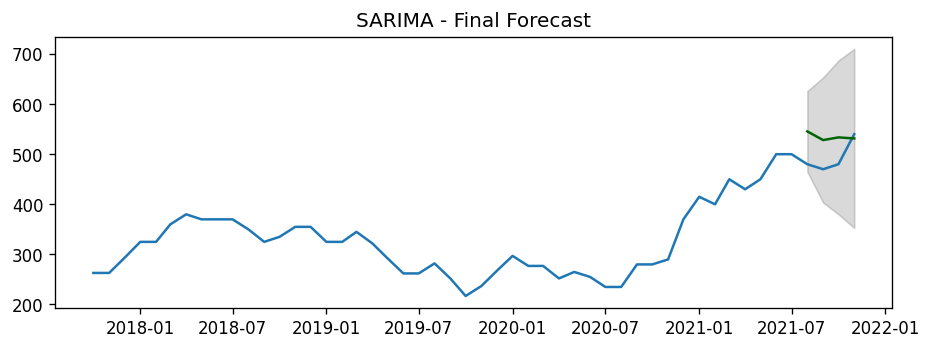

In [ ]:
smodel = pm.auto_arima(df.value, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=21,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
smodel.summary()

# Forecast
n_periods = 4
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = list(range(df.index[-1], df.index[-1] + n_periods))
#pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=df.index[-n_periods:])
lower_series = pd.Series(confint[:, 0], index=df.index[-n_periods:])
upper_series = pd.Series(confint[:, 1], index=df.index[-n_periods:])

# Plot
plt.plot(df.value[-50:])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()

In [ ]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  207
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 21)   Log Likelihood                -956.311
Date:                             Tue, 07 Dec 2021   AIC                           1922.622
Time:                                     15:14:10   BIC                           1938.724
Sample:                                          0   HQIC                          1929.148
                                             - 207                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4159      0.266     -1.563      0.118      -0.937       0.106
ma.L1          0.5981      0.247      2.423      0.015       0.114       1.082
ar.S.L21      -0.7480      0.070    -10.644      0.000      -0.886      -0.610
ar.S.L42      -0.2985      0.069     -4.314      0.000      -0.434      -0.163
sigma2      1691.9135    179.015      9.451      0.000    1341.051    2042.776
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.36
Prob(Q):                              0.87   Prob(JB):                         0.31
Heteroskedasticity (H):               0.39   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
seasonal_comps = list(range(12, 31))
AICs = []
BICs = []
orders = []
seasonal_orders = []
for comp in seasonal_comps:
  smodel = pm.auto_arima(df.value, start_p=1, start_q=1,
                          test='adf',
                          max_p=3, max_q=3, m=comp,
                          start_P=0, D=1, seasonal=True,
                          d=None, trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True
                         )
  
  AICs.append(round(smodel.aic(), 4))
  BICs.append(round(smodel.bic(), 4))
  orders.append(smodel.order)
  seasonal_orders.append(smodel.seasonal_order)

models_result = pd.DataFrame({"Order":orders,
                              "Seasonal order":seasonal_orders,
                              "AIC":AICs,
                              "BIC":BICs}
                             )

KeyboardInterrupt: ignored

In [ ]:
models_result.sort_values('AIC')

#From a previous analysis the best result by AIC and BIC were:
#(1, 1, 1)	(2, 1, 0, 30)	AIC: 1821.5435	BIC: 1837.3959
#(1, 1, 1)	(2, 1, 0, 29)	AIC: 1843.5773	BIC: 1859.4581
#(2, 1, 1)	(2, 1, 0, 28)	AIC: 1847.8963	BIC: 1866.9870
#(3, 1, 0)	(2, 1, 1, 26)	AIC: 1860.0235	BIC: 1882.3742
#(3, 1, 0)	(2, 1, 0, 27)	AIC: 1863.3028	BIC: 1882.4271

,Order,Seasonal order,AIC,BIC
20,"(3, 1, 0)","(2, 1, 1, 26)",1860.0235,1882.3742
21,"(3, 1, 0)","(2, 1, 0, 27)",1863.3028,1882.4271
18,"(1, 1, 0)","(1, 1, 1, 24)",1873.7867,1886.6027
19,"(0, 1, 1)","(2, 1, 1, 25)",1884.0352,1900.0277
17,"(3, 1, 0)","(2, 1, 0, 23)",1908.0563,1927.3132
16,"(0, 1, 2)","(2, 1, 0, 22)",1910.0036,1926.0783
14,"(0, 1, 2)","(2, 1, 1, 20)",1916.5446,1935.8991
15,"(1, 1, 1)","(2, 1, 0, 21)",1922.6224,1938.7242
12,"(2, 0, 1)","(2, 1, 0, 18)",1945.2608,1964.7113
13,"(2, 1, 0)","(2, 1, 0, 19)",1948.2404,1964.3959


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

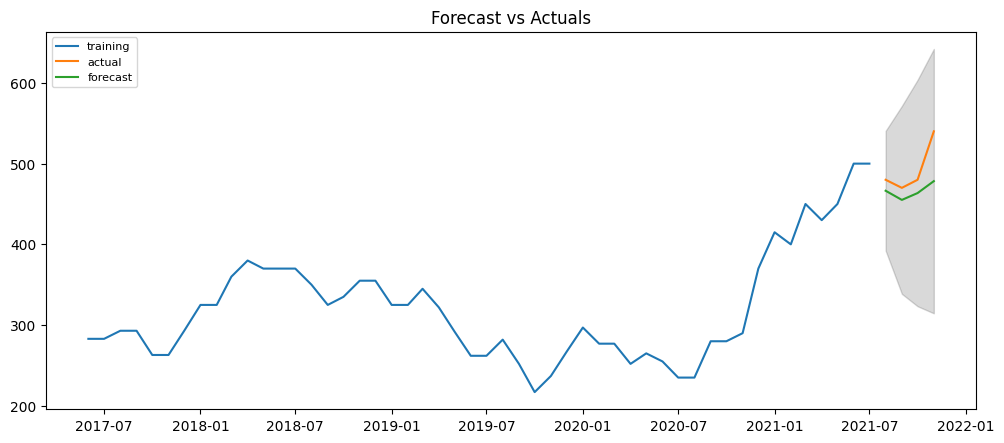

In [ ]:
ns = 4
# Create Training and Test
train = df.value[:-ns]
test = df.value[-ns:]

#Best univariate model with seasonality: (3, 1, 0)([2], 1, 1, 26)
smodel = ARIMA(train, order=(3, 1, 0), seasonal_order=([2], 1, 1, 26)).fit()

# Forecast
#fc, se, conf = fitted.forecast(df.shape[0]-ns, alpha=0.05)  # 95% conf
forecasted = smodel.get_forecast(ns, alpha=0.05).summary_frame()  # 95% conf
forecasted.index = test.index

# Make as pandas series
#fc_series = pd.Series(fc, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-50:], label='training')
plt.plot(test, label='actual')
plt.plot(forecasted['mean'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
#                 color='k', alpha=.15)
plt.fill_between(forecasted.index, forecasted['mean_ci_lower'], forecasted['mean_ci_upper'],
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
forecast_accuracy(forecasted['mean'], test.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if sys.path[0] == '':


{'acf1': -0.05155083115583178,
 'corr': 0.9276510433637556,
 'mae': 26.666176477701697,
 'mape': 0.05215051960194693,
 'me': -26.666176477701697,
 'minmax': 0.05215051960194694,
 'mpe': -0.05215051960194693,
 'rmse': 33.4783118543865,
 'wape': 0.054144520766907}

## **SARIMAX model using seasonal component as exogenous variable**

In [ ]:
df.set_index('Month', inplace=True)

In [ ]:
data = df.copy()

# Compute Seasonal Index
# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq',
                                period=12)

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df_seasonal = pd.merge(data[['value', 'month']], seasonal_index, how='left', on='month')
df_seasonal.columns = ['value', 'month', 'seasonal_index']
df_seasonal.index = data.index  # reassign the index

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (26) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2051.202, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2060.659, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2056.923, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2054.203, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2059.451, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2052.371, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2052.603, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2050.970, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2052.386, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2054.373, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2049.707, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2052.791, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2051.312, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2051.053, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]          

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


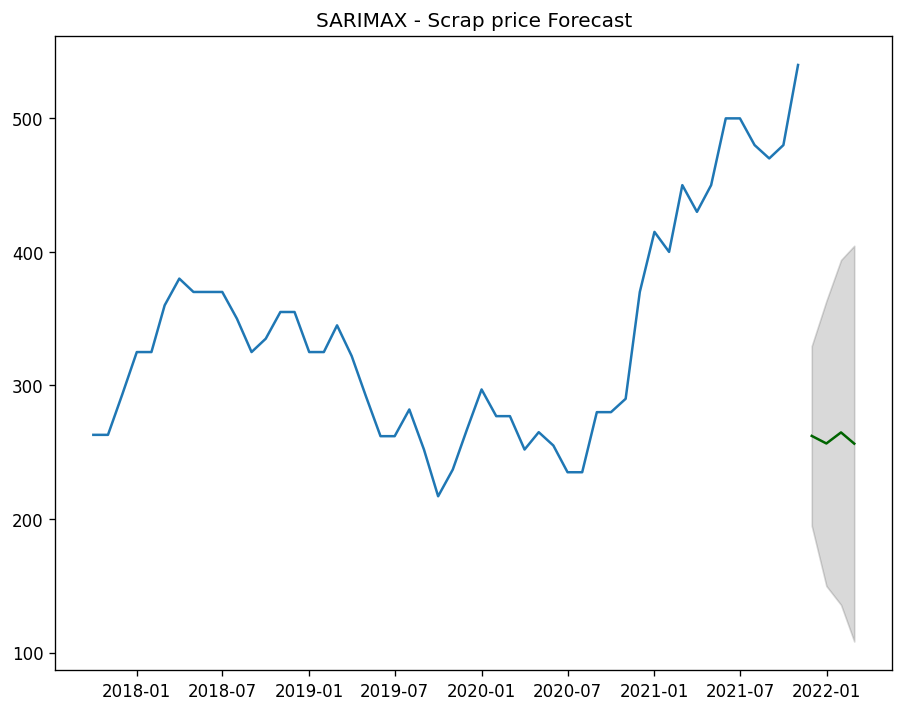

In [ ]:
## ========  Sarimax model putting seasonal component as exogenous variable

# SARIMAX Model
train = df_seasonal.iloc[:-n_periods]
test = df_seasonal.iloc[-n_periods:]

sxmodel = pm.auto_arima(df_seasonal[['value']], exogenous=df_seasonal[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=26,
                           start_P=0, seasonal=False,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()
# Forecast
n_periods = 4
fitted, confint = sxmodel.predict(n_periods=n_periods, return_conf_int=True, exogenous= -df_seasonal[['seasonal_index']].iloc[-n_periods:])
    
index_of_fc = list(pd.date_range(df.index[-1], df_seasonal.index[-1] + relativedelta(months=n_periods),freq='M'))
#pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df_seasonal.value[-50:])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX - Scrap price Forecast")
plt.show()

## **SARIMAX model with other exogenous variables**

In [ ]:
df.columns

Index(['Scrap_Price', 'scrap_trend', 'scrap_seasonality', 'scrap_resid',
       'INTDSRUSM193N', 'TTLCONS', 'CCRETT01USM661N', 'PCOPPUSDM',
       'PIORECRUSDM', 'CPIAUCSL', 'POILWTIUSDM', 'CPIHOSSL', 'CAPUTLG333S',
       'DAUPSA', 'WPU1012', 'IPN3311A2RS', 'Covid', 'Aranceles_acero',
       'FED_meetings', 'FED_meetings_adjusted', 'Financial_crisis',
       'US_elections', 'Delta_Scrap_Price', 'value'],
      dtype='object')

In [ ]:
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3



exog_vars = [['CCRETT01USM661N', 'PCOPPUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],

             ['CCRETT01USM661N', 'POILWTIUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],    
]

## **Algoritmos de búsqueda exhaustiva**


## **Búsqueda con modelos de pocas variables**

In [ ]:
#Modelo con todas las variables diferenciadas
diff_df = df.copy().diff().iloc[1:]
diff_df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].iloc[1:]

n_periods = 4
n_lags = 1
train_diff = diff_df[-120:-n_periods]
test_diff = diff_df[-n_periods:]

train = df.iloc[-120:-n_periods]
test = df.iloc[-n_periods:]

seasonal_comps = [12, 21, 24, 26, 30]
season_comps = []
AICs = []
BICs = []
RMSEs = []
orders = []
seasonal_orders = []
model_exogs = []


for exogs in exog_vars:
  for season_comp in seasonal_comps:
      sxmodel = pm.auto_arima(train_diff[['value']], exogenous=train_diff[exogs],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=season_comp,
                              start_P=0, D=1, seasonal=True,
                              d=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True
                              )
      season_comps.append(season_comp)
      AICs.append(round(sxmodel.aic(), 4))
      BICs.append(round(sxmodel.bic(), 4))
      RMSEs.append(round(np.mean(sxmodel.resid()**2)**(1/2), 4))
      orders.append(sxmodel.order)
      seasonal_orders.append(sxmodel.seasonal_order)
      model_exogs.append(exogs)


models_result = pd.DataFrame({"Order":orders,
                              "Seasonal order":seasonal_orders,
                              "AIC":AICs,
                              "BIC":BICs,
                              "RMSE":RMSEs,
                              "Seasonal comp":season_comps}
                             )

In [ ]:
models_result.sort_values('RMSE')

,Order,Seasonal order,AIC,BIC,RMSE,Seasonal comp
10,"(0, 1, 2)","(0, 1, 2, 12)",985.0682,1019.3197,53.1912,12
15,"(1, 1, 1)","(0, 1, 2, 12)",995.2823,1024.2643,53.4114,12
5,"(1, 1, 1)","(0, 1, 1, 12)",986.1401,1015.1221,53.8465,12
0,"(2, 1, 0)","(0, 1, 2, 12)",990.6013,1022.2180,53.9798,12
20,"(0, 1, 0)","(1, 1, 1, 12)",1000.4059,1024.1185,54.4950,12
17,"(0, 1, 0)","(0, 1, 1, 24)",891.3439,911.4307,56.8232,24
13,"(1, 1, 1)","(0, 1, 1, 26)",881.9787,911.8423,56.9050,26
18,"(1, 1, 1)","(0, 1, 1, 26)",893.9661,921.3411,57.0102,26
12,"(0, 1, 2)","(0, 1, 1, 24)",884.4958,912.1152,57.1878,24
19,"(0, 1, 1)","(0, 1, 1, 30)",836.8849,861.3114,57.2222,30


In [ ]:
model_exogs

In [ ]:
models_result.to_excel("models_results.xlsx")

## **Búsqueda con modelos potenciales**

In [ ]:
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3



exog_vars = [['CCRETT01USM661N', 'PCOPPUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],

             ['CCRETT01USM661N', 'POILWTIUSDM', 'PCOPPUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
              ['CCRETT01USM661N', 'POILWTIUSDM', 'PCOPPUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],            
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'TTLCONS', 'IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],       
]

In [ ]:
#Modelo con todas las variables diferenciadas
diff_df = df.copy().diff().iloc[1:]
diff_df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].iloc[1:]

n_periods = 4
n_lags = 1
train_diff = diff_df[-120:-n_periods]
test_diff = diff_df[-n_periods:]

train = df.iloc[-120:-n_periods]
test = df.iloc[-n_periods:]

seasonal_comps = [12, 21, 24, 30]
season_comps = []
AICs = []
BICs = []
RMSEs = []
orders = []
seasonal_orders = []
model_exogs = []


for exogs in exog_vars:
  for season_comp in seasonal_comps:
      sxmodel = pm.auto_arima(train_diff[['value']], exogenous=train_diff[exogs],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=season_comp,
                              start_P=0, D=1, seasonal=True,
                              d=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True
                              )
      season_comps.append(season_comp)
      AICs.append(round(sxmodel.aic(), 4))
      BICs.append(round(sxmodel.bic(), 4))
      RMSEs.append(round(np.mean(sxmodel.resid()**2)**(1/2), 4))
      orders.append(sxmodel.order)
      seasonal_orders.append(sxmodel.seasonal_order)
      model_exogs.append(exogs)


models_result = pd.DataFrame({"Order":orders,
                              "Seasonal order":seasonal_orders,
                              "AIC":AICs,
                              "BIC":BICs,
                              "RMSE":RMSEs,
                              "Seasonal comp":season_comps}
                             )

In [ ]:
models_result.sort_values('RMSE')

,Order,Seasonal order,AIC,BIC,RMSE,Seasonal comp
16,"(0, 1, 2)","(1, 1, 1, 12)",981.4101,1018.2963,52.5961,12
4,"(1, 1, 1)","(0, 1, 1, 12)",988.2212,1019.8379,53.5453,12
24,"(0, 1, 0)","(1, 1, 1, 12)",995.9333,1024.9153,53.5961,12
8,"(2, 1, 1)","(1, 1, 1, 12)",991.2404,1030.7613,53.7201,12
12,"(0, 1, 2)","(0, 1, 1, 12)",991.2772,1025.5286,53.8101,12
0,"(1, 1, 0)","(1, 1, 1, 12)",995.1891,1026.8059,54.1692,12
20,"(0, 1, 1)","(0, 1, 1, 12)",995.0103,1023.9923,54.5076,12
28,"(0, 1, 0)","(1, 1, 1, 12)",1000.9361,1029.9181,54.6143,12
18,"(0, 1, 2)","(0, 1, 1, 24)",875.0443,907.6855,55.8985,24
26,"(0, 1, 1)","(1, 1, 0, 24)",884.4278,912.0472,56.4859,24


In [ ]:
model_exogs[8]

In [ ]:
models_result.to_excel("models_result_complexmod.xlsx")

## **Búsqueda con modelos sin componente estacional**

In [ ]:
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3



exog_vars = [['CCRETT01USM661N', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PCOPPUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PCOPPUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PCOPPUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],

             ['CCRETT01USM661N', 'POILWTIUSDM', 'PCOPPUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
              ['CCRETT01USM661N', 'POILWTIUSDM', 'PCOPPUSDM', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],            
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM', 'IPN3311A2RS', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'POILWTIUSDM', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'TTLCONS', 'IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM', 'TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],       
]

In [ ]:
#Modelo con todas las variables diferenciadas
diff_df = df.copy().diff().iloc[1:]
diff_df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].iloc[1:]

n_periods = 4
n_lags = 1
train_diff = diff_df[-120:-n_periods]
test_diff = diff_df[-n_periods:]

train = df.iloc[-120:-n_periods]
test = df.iloc[-n_periods:]

AICs = []
BICs = []
RMSEs = []
orders = []
model_exogs = []


for exogs in exog_vars:
      sxmodel = pm.auto_arima(train_diff[['value']], exogenous=train_diff[exogs],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3,
                              start_P=0, D=None, seasonal=False,
                              d=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True
                              )
      AICs.append(round(sxmodel.aic(), 4))
      BICs.append(round(sxmodel.bic(), 4))
      RMSEs.append(round(np.mean(sxmodel.resid()**2)**(1/2), 4))
      orders.append(sxmodel.order)
      model_exogs.append(exogs)


models_result = pd.DataFrame({"Order":orders,
                              "AIC":AICs,
                              "BIC":BICs,
                              "RMSE":RMSEs}
                             )

In [ ]:
models_result.sort_values('RMSE')

,Order,AIC,BIC,RMSE
14,"(1, 1, 1)",1081.0150,1113.9542,49.7170
13,"(1, 1, 3)",1077.5432,1113.2273,49.7823
1,"(0, 1, 2)",1077.4233,1104.8726,49.9032
10,"(0, 1, 3)",1080.1080,1113.0472,49.9231
3,"(1, 1, 3)",1079.0894,1114.7735,49.9747
12,"(1, 1, 2)",1079.8257,1115.5098,49.9860
15,"(0, 1, 2)",1084.4322,1117.3714,49.9913
17,"(1, 1, 2)",1082.3725,1115.3117,50.0179
9,"(2, 1, 1)",1078.6973,1111.6365,50.1229
6,"(2, 1, 1)",1078.6973,1111.6365,50.1229


In [ ]:
model_exogs[10]

['CCRETT01USM661N',
 'POILWTIUSDM',
 'PIORECRUSDM',
 'Covid',
 'Aranceles_acero',
 'FED_meetings_adjusted',
 'Financial_crisis',
 'US_elections']

In [ ]:
models_result.to_excel("models_result_noseasonality.xlsx")

## **Pruebas con modelos sencillos de 2 diferenciaciones


In [ ]:
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3



exog_vars = [['CCRETT01USM661N', 'PCOPPUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['CCRETT01USM661N', 'PIORECRUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],

             ['CCRETT01USM661N', 'POILWTIUSDM',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['IPN3311A2RS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],
             
             ['TTLCONS',
              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections'],    
]

In [ ]:
#Modelo con todas las variables diferenciadas
diff_df = df.copy().diff().diff().iloc[1:]
diff_df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].iloc[1:]

n_periods = 4
n_lags = 1
train_diff = diff_df[-120:-n_periods]
test_diff = diff_df[-n_periods:]

train = df.iloc[-120:-n_periods]
test = df.iloc[-n_periods:]

seasonal_comps = [12, 21, 24, 26, 30]
season_comps = []
AICs = []
BICs = []
RMSEs = []
orders = []
seasonal_orders = []
model_exogs = []


for exogs in exog_vars:
  for season_comp in seasonal_comps:
      sxmodel = pm.auto_arima(train_diff[['value']], exogenous=train_diff[exogs],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=season_comp,
                              start_P=0, D=2, seasonal=True,
                              d=2, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True
                              )
      season_comps.append(season_comp)
      AICs.append(round(sxmodel.aic(), 4))
      BICs.append(round(sxmodel.bic(), 4))
      RMSEs.append(round(np.mean(sxmodel.resid()**2)**(1/2), 4))
      orders.append(sxmodel.order)
      seasonal_orders.append(sxmodel.seasonal_order)
      model_exogs.append(exogs)


models_result = pd.DataFrame({"Order":orders,
                              "Seasonal order":seasonal_orders,
                              "AIC":AICs,
                              "BIC":BICs,
                              "RMSE":RMSEs,
                              "Seasonal comp":season_comps}
                             )

In [ ]:
models_result.sort_values('AIC')

,Order,Seasonal order,AIC,BIC,RMSE,Seasonal comp
9,"(0, 2, 1)","(1, 2, 0, 30)",606.1234,626.0133,87.6527,30
4,"(2, 2, 1)","(1, 2, 0, 30)",607.0256,630.8935,86.2403,30
24,"(0, 2, 2)","(1, 2, 0, 30)",610.9395,630.8293,87.4578,30
14,"(0, 2, 0)","(1, 2, 0, 30)",614.8070,632.7079,88.3589,30
19,"(2, 2, 0)","(1, 2, 0, 30)",615.0840,634.9738,89.1226,30
3,"(0, 2, 3)","(1, 2, 0, 26)",686.3450,711.8706,89.0125,26
13,"(2, 2, 0)","(1, 2, 0, 26)",686.9338,710.3323,86.9269,26
8,"(2, 2, 0)","(1, 2, 0, 26)",689.4422,712.8407,89.7051,26
18,"(2, 2, 3)","(2, 2, 0, 26)",693.3018,723.0817,92.1441,26
23,"(0, 2, 3)","(0, 2, 1, 26)",697.5822,720.9807,92.5898,26


In [ ]:
model_exogs[4]

['CCRETT01USM661N',
 'PCOPPUSDM',
 'Covid',
 'Aranceles_acero',
 'FED_meetings_adjusted',
 'Financial_crisis',
 'US_elections']

## **Prueba de modelos personalizados**

In [ ]:
df.columns

Index(['Scrap_Price', 'scrap_trend', 'scrap_seasonality', 'scrap_resid',
       'INTDSRUSM193N', 'TTLCONS', 'CCRETT01USM661N', 'PCOPPUSDM',
       'PIORECRUSDM', 'CPIAUCSL', 'POILWTIUSDM', 'CPIHOSSL', 'CAPUTLG333S',
       'DAUPSA', 'WPU1012', 'IPN3311A2RS', 'Covid', 'Aranceles_acero',
       'FED_meetings', 'FED_meetings_adjusted', 'Financial_crisis',
       'US_elections', 'Delta_Scrap_Price', 'value', 'INTDSRUSM193N_2',
       'INTDSRUSM193N_3'],
      dtype='object')

In [ ]:
#Mejores modelos hasta el momento en pruebas manuales con componente estacional de 26:
#SARIMAX(1, 1, 1)x(0, 1, 1, 26) ['CCRETT01USM661N', 'PCOPPUSDM']        AIC: 884.193    BIC: 906.590
#SARIMAX(1, 1, 1)x(0, 1, 1, 26) ['CCRETT01USM661N', 'POILWTIUSDM']        AIC: 874.075    BIC: 896.472
#SARIMAX(1, 1, 1)x(0, 1, 1, 26) ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM']        AIC: 871.094    BIC: 895.980


#Mejores modelos sencillos hasta el momento según RMSE:
#SARIMAX(0, 1, 2)x(0, 1, 2, 12) ['CCRETT01USM661N', 'POILWTIUSDM']        AIC: 985.068    BIC: 1019.3197
#SARIMAX(1, 1, 1)x(0, 1, 2, 12) ['CCRETT01USM661N', 'IPN3311A2RS']        AIC: 995.282    BIC: 1024.2643
#SARIMAX(1, 1, 1)x(0, 1, 1, 12) ['CCRETT01USM661N', 'PIORECRUSDM']        AIC: 986.140    BIC: 1015.122


#Mejores modelos sencillos hasta el momento según AIC:
#SARIMAX(1, 1, 1)x(2, 1, 0, 30) ['TTLCONS']        AIC: 830.277    BIC: 862.032
#SARIMAX(0, 1, 3)x(1, 1, 0, 30) ['CCRETT01USM661N', 'PCOPPUSDM']        AIC: 830.559    BIC: 859.870
#SARIMAX(1, 1, 2)x(2, 1, 0, 12) ['CCRETT01USM661N', 'PIORECRUSDM']        AIC: 831.144    BIC: 862.898


#Mejores modelos complejos hasta el momento según AIC:
#SARIMAX(1, 1, 1)x(2, 1, 0, 30) ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS']        AIC: 826.286    BIC: 860.483
#SARIMAX(1, 1, 2)x(2, 1, 0, 30) ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM']        AIC: 832.616    BIC: 866.813
#SARIMAX(1, 1, 1)x(2, 1, 0, 30) ['CCRETT01USM661N', 'POILWTIUSDM', 'PCOPPUSDM']        AIC: 833.133    BIC: 864.888

#Mejores modelos complejos hasta el momento según RMSE:
#SARIMAX(0, 1, 2)x(1, 1, 1, 12) ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS']        AIC: 981.410    BIC: 1018.296
#SARIMAX(1, 1, 1)x(0, 1, 1, 12) ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM']        AIC: 988.221    BIC: 1019.837
#SARIMAX(0, 1, 0)x(1, 1, 1, 12) ['CCRETT01USM661N', 'TTLCONS', 'IPN3311A2RS']        AIC: 995.933    BIC: 1024.915

#Mejores modelos sin componente estacional según AIC:
#ARIMAX(2, 1, 1) ['CCRETT01USM661N', 'PCOPPUSDM']        AIC: 1077.225    BIC: 1107.419
#ARIMAX(1, 1, 1) ['CCRETT01USM661N', 'POILWTIUSDM', 'TTLCONS']        AIC: 1077.259    BIC: 1107.454
#ARIMAX(0, 1, 2) ['CCRETT01USM661N', 'IPN3311A2RS']        AIC: 1077.423    BIC: 1104.872

#Mejores modelos sin componente estacional según RMSE:
#ARIMAX(1, 1, 1) ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS', 'TTLCONS']        AIC: 1081.015    BIC: 1113.954
#ARIMAX(1, 1, 3) ['CCRETT01USM661N', 'POILWTIUSDM', 'IPN3311A2RS']        AIC: 1077.543    BIC: 1113.227
#ARIMAX(0, 1, 3) ['CCRETT01USM661N', 'POILWTIUSDM', 'PIORECRUSDM']        AIC: 1080.108    BIC: 1113.047


#Mejores modelos con 2 diferenciaciones y componente estacional según AIC:

In [ ]:
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().diff().iloc[1:]
diff_df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['value', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
diff_df['PCOPPUSDM_1'] = diff_df['PCOPPUSDM'].shift(1)
diff_df['PCOPPUSDM_2'] = diff_df['PCOPPUSDM'].shift(2)
diff_df['PCOPPUSDM_3'] = diff_df['PCOPPUSDM'].shift(3)
diff_df['PCOPPUSDM_4'] = diff_df['PCOPPUSDM'].shift(4)
diff_df['CCRETT01USM661N_1'] = diff_df['CCRETT01USM661N'].shift(1)
diff_df['CCRETT01USM661N_2'] = diff_df['CCRETT01USM661N'].shift(2)
diff_df['CCRETT01USM661N_3'] = diff_df['CCRETT01USM661N'].shift(3)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
diff_df['PIORECRUSDM_1'] = diff_df['PIORECRUSDM'].shift(1)
diff_df['PIORECRUSDM_2'] = diff_df['PIORECRUSDM'].shift(2)
diff_df['PIORECRUSDM_3'] = diff_df['PIORECRUSDM'].shift(3)
diff_df['PIORECRUSDM_4'] = diff_df['PIORECRUSDM'].shift(4)
diff_df['PIORECRUSDM_5'] = diff_df['PIORECRUSDM'].shift(5)
diff_df['PIORECRUSDM_6'] = diff_df['PIORECRUSDM'].shift(6)
diff_df['POILWTIUSDM_1'] = diff_df['POILWTIUSDM'].shift(1)
diff_df['POILWTIUSDM_2'] = diff_df['POILWTIUSDM'].shift(2)
diff_df['POILWTIUSDM_3'] = diff_df['POILWTIUSDM'].shift(3)
diff_df['POILWTIUSDM_4'] = diff_df['POILWTIUSDM'].shift(4)
diff_df['POILWTIUSDM_5'] = diff_df['POILWTIUSDM'].shift(5)
diff_df['POILWTIUSDM_6'] = diff_df['POILWTIUSDM'].shift(6)
diff_df['POILWTIUSDM_12'] = diff_df['POILWTIUSDM'].shift(12)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)



n_periods = 4
n_lags = 1
train_diff = diff_df[-120:-n_periods]
test_diff = diff_df[-n_periods-n_lags:]

train = df.iloc[-120:-n_periods]
test = df.iloc[-n_periods-n_lags:]

#exogs = ['CCRETT01USM661N', 'PCOPPUSDM', 'PIORECRUSDM', 'POILWTIUSDM', 'INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
#              'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']

exogs = ['POILWTIUSDM_1', 'PIORECRUSDM_1', 'PCOPPUSDM_1', 'CCRETT01USM661N_1',
         'Covid', 'Aranceles_acero', 'US_elections']


model = pm.auto_arima(train_diff[['value']], exogenous=train_diff[exogs],
                      start_p=1, start_q=1,
                      test='adf',
                      max_p=3, max_q=3, m=26,
                      start_P=0, D=2, seasonal=True,
                      d=2, trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True
                      )


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,2,1)[26]             : AIC=691.770, Time=16.14 sec
 ARIMA(0,2,0)(0,2,0)[26]             : AIC=719.181, Time=3.95 sec
 ARIMA(1,2,0)(1,2,0)[26]             : AIC=699.455, Time=15.43 sec
 ARIMA(0,2,1)(0,2,1)[26]             : AIC=691.259, Time=16.15 sec
 ARIMA(0,2,1)(0,2,0)[26]             : AIC=696.362, Time=7.57 sec
 ARIMA(0,2,1)(1,2,1)[26]             : AIC=693.278, Time=15.93 sec
 ARIMA(0,2,1)(0,2,2)[26]             : AIC=693.548, Time=30.22 sec
 ARIMA(0,2,1)(1,2,0)[26]             : AIC=691.066, Time=14.72 sec
 ARIMA(0,2,1)(2,2,0)[26]             : AIC=692.988, Time=34.06 sec
 ARIMA(0,2,1)(2,2,1)[26]             : AIC=696.855, Time=32.40 sec
 ARIMA(0,2,0)(1,2,0)[26]             : AIC=707.167, Time=12.79 sec
 ARIMA(1,2,1)(1,2,0)[26]             : AIC=inf, Time=16.60 sec
 ARIMA(0,2,2)(1,2,0)[26]             : AIC=685.146, Time=16.18 sec
 ARIMA(0,2,2)(0,2,0)[26]             : AIC=inf, Time=7.47 sec
 ARIMA(0,2,2)(2,2,0)[26]      

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  116
Model:             SARIMAX(0, 2, 3)x(0, 2, [1], 26)   Log Likelihood                -326.072
Date:                              Thu, 09 Dec 2021   AIC                            676.144
Time:                                      20:54:21   BIC                            701.670
Sample:                                           0   HQIC                           686.166
                                              - 116                                         
Covariance Type:                                opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
POILWTIUSDM_1         0.1891      0.191      0.991      0.322      -0.185       0.563
PIORECRUSDM_1         0.1322      0.223      0.593      0.553      -0.304       0.569
PCOPPUSDM_1           0.0021      0.002      0.853      0.394      -0.003       0.007
CCRETT01USM661N_1    -1.7680      1.174     -1.506      0.132      -4.069       0.533
Covid               -55.3625     49.421     -1.120      0.263    -152.225      41.500
Aranceles_acero      -1.4898     40.619     -0.037      0.971     -81.102      78.123
US_elections        -38.0229     15.921     -2.388      0.017     -69.227      -6.819
ma.L1                -0.3905      0.420     -0.930      0.352      -1.213       0.432
ma.L2                -0.9443      0.495     -1.908      0.056      -1.914       0.026
ma.L3                 0.3615      0.248      1.461      0.144      -0.124       0.847
ma.S.L26             -0.4881      0.466     -1.046      0.295      -1.402       0.426
sigma2             2353.0131   1173.442      2.005      0.045      53.109    4652.917
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.68   Prob(JB):                         0.67
Heteroskedasticity (H):               0.55   Skew:                             0.26
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Modelos potenciales (variables significativas) de los escogidos con filtros anteriores:
#SARIMAX(1, 1, 1)x(0, 1, 1, 26) ['CCRETT01USM661N', 'POILWTIUSDM']        AIC: 874.075    BIC: 896.472     1 lag
#SARIMAX(1, 1, 1)x(0, 1, 1, 12) ['CCRETT01USM661N', 'PIORECRUSDM']        AIC: 986.140    BIC: 1015.122    1 lag
#SARIMAX(0, 1, 2)x(0, 1, 2, 12) ['CCRETT01USM661N', 'POILWTIUSDM']        AIC: 985.068    BIC: 1019.3197   1 lag

#SARIMAX(0, 1, [1, 3])x(0, 1, 1, 30) ['CCRETT01USM661N', 'PCOPPUSDM']        AIC: 829.144    BIC: 853.144       1 lag
#SARIMAX(0, 1, [1, 3])x(0, 1, 1, 30) ['CCRETT01USM661N', 'PIORECRUSDM']        AIC: 823.832    BIC: 848.258    1 lag
#SARIMAX(1, 1, 1)x(1, 1, 1, 12) ['CCRETT01USM661N', 'PIORECRUSDM']        AIC: 831.144    BIC: 862.898   1 lag
#SARIMAX(0, 1, 1)x(0, 1, 1, 21) ['POILWTIUSDM', 'PIORECRUSDM', 'TTLCONS']        AIC: 914.743    BIC: 937.633   1 lag

#SARIMAX(0, 1, 1) ['POILWTIUSDM', 'PIORECRUSDM', 'TTLCONS']        AIC: 1063.566    BIC: 1085.525   1 lag



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


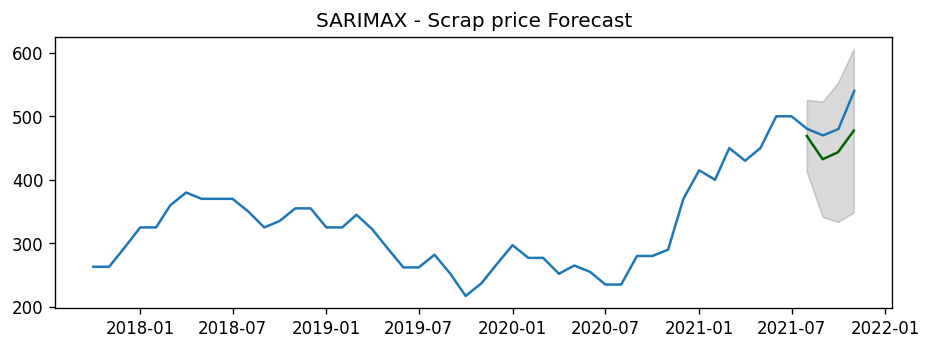

In [ ]:
# Forecast
n_periods = 4
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True, exogenous= test_diff[exogs].iloc[-n_periods:])
    
index_of_fc = list(pd.date_range(train.index[-1], train.index[-1] + relativedelta(months=n_periods),freq='M'))
#pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value[-50:])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX - Scrap price Forecast")
plt.show()

In [ ]:
fitted

array([482.56170341, 463.90310543, 474.72259709, 505.28709215])

## **Grid search para modelo ARIMA**

Source: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
      model = ARIMA(history, order=arima_order)
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      history.append(test[t])
    # calculate out of sample error
    error = np.mean((test - predictions)**2)**(1/2)
    return error

In [ ]:
evaluate_arima_model(df['value'], (3, 1, 2))

25.95289343316639

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

evaluate_models(df['value'], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=80.525
ARIMA(0, 0, 1) MSE=49.938
ARIMA(0, 0, 2) MSE=37.298
ARIMA(0, 0, 3) MSE=34.518
ARIMA(0, 1, 0) MSE=26.552
ARIMA(0, 1, 1) MSE=26.086
ARIMA(0, 1, 2) MSE=26.095
ARIMA(0, 1, 3) MSE=26.216
ARIMA(0, 2, 0) MSE=33.619
ARIMA(0, 2, 1) MSE=26.408
ARIMA(0, 2, 2) MSE=25.995
ARIMA(0, 2, 3) MSE=25.947
ARIMA(1, 0, 0) MSE=27.031
ARIMA(1, 0, 1) MSE=26.497
ARIMA(1, 0, 2) MSE=26.487
ARIMA(1, 0, 3) MSE=26.674
ARIMA(1, 1, 0) MSE=26.214
ARIMA(1, 1, 1) MSE=26.183
ARIMA(1, 1, 2) MSE=26.165
ARIMA(1, 1, 3) MSE=26.450
ARIMA(1, 2, 0) MSE=31.874
ARIMA(1, 2, 1) MSE=26.107
ARIMA(1, 2, 2) MSE=26.077
ARIMA(1, 2, 3) MSE=26.030
ARIMA(2, 0, 0) MSE=26.628
ARIMA(2, 0, 1) MSE=26.573
ARIMA(2, 0, 2) MSE=26.597
ARIMA(2, 0, 3) MSE=26.552
ARIMA(2, 1, 0) MSE=25.990
ARIMA(2, 1, 1) MSE=26.115
ARIMA(2, 1, 2) MSE=26.048
ARIMA(2, 1, 3) MSE=26.339
ARIMA(2, 2, 0) MSE=29.363
ARIMA(2, 2, 1) MSE=25.836
ARIMA(2, 2, 2) MSE=25.984
ARIMA(2, 2, 3) MSE=25.928
ARIMA(3, 0, 0) MSE=26.422
ARIMA(3, 0, 1) MSE=26.464
ARIMA(3, 0, 

## **Grid search para modelo SARIMA**

In [ ]:
# evaluate a SARIMA model for a given order (p,d,q) (P, D, Q, S)
def evaluate_sarima_model(X, arima_order, seasonal_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
      model = ARIMA(history, order=arima_order, seasonal_order=seasonal_order)
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      predictions.append(yhat)
      history.append(test[t])
    # calculate out of sample error
    error = np.mean((test - predictions)**2)**(1/2)
    return error

In [ ]:
order = (1, 1, 3)
seas_order = (1, 1, 2, 12)

evaluate_sarima_model(df['value'], order, seas_order)

NameError: ignored

In [ ]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
  dataset = dataset.astype('float32')
  best_score, best_cfg, best_so = float("inf"), None, None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        for P in P_values:
          for D in D_values:
            for Q in Q_values:
              for S in S_values:
                order = (p, d, q)
                seasonal_order = (P, D, Q, S)
                try:
                  rmse = evaluate_sarima_model(dataset, order, seasonal_order)
                  if rmse < best_score:
                    best_score, best_cfg, best_so = rmse, order, seasonal_order
                  print('ARIMA%s RMSE=%.3f' % (order, seasonal_order, rmse))
                except:
                  continue
  print('Best ARIMA%s %s RMSE=%.3f' % (best_cfg, best_so, best_score))

In [ ]:
p_values = [0, 1, 2, 3]
d_values = [1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [1]
Q_values = [0, 1, 2, 3]
S_values = [12, 15, 18, 21, 24, 26, 30]

evaluate_models(df['value'], p_values, d_values, q_values, P_values, D_values, Q_values, S_values)

## **Búsqueda de los retrazos significativos por variable**

In [ ]:
#Las siguientes variables son las que parecen útiles para predecir los precios de la chatarra teniendo en cuenta retrazos de la misma variable del precio del scrap:
#CCRETT01USM661N
#POILWTIUSDM
#PIORECRUSDM
#PCOPPUSDM
#TTLCONS

In [ ]:
#Análisis para CCRETT01USM661N
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ + value.shift(1) + value.shift(2) + value.shift(3) + value.shift(4) + CCRETT01USM661N.shift(1) + CCRETT01USM661N.shift(2) + CCRETT01USM661N.shift(3) + CCRETT01USM661N.shift(4) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     3.606
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           0.000165
Time:                        18:00:29   Log-Likelihood:                -532.26
No. Observations:                 116   AIC:                             1091.
Df Residuals:                     103   BIC:                             1126.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3139      3.339     -0.693      0.490      -8.937       4.309
value.shift(1)               0.1302      0.099      1.313      0.192      -0.067       0.327
value.shift(2)              -0.3343      0.097     -3.437      0.001      -0.527      -0.141
value.shift(3)               0.2173      0.096      2.270      0.025       0.027       0.407
value.shift(4)              -0.1214      0.092     -1.316      0.191      -0.305       0.062
CCRETT01USM661N.shift(1)   -10.7711      2.171     -4.961      0.000     -15.077      -6.465
CCRETT01USM661N.shift(2)     6.2193      2.486      2.501      0.014       1.288      11.150
CCRETT01USM661N.shift(3)    -4.6371      2.462     -1.884      0.062      -9.519       0.245
CCRETT01USM661N.shift(4)    -1.0263      2.255     -0.455      0.650      -5.499       3.446
Covid                       -4.8159      9.495     -0.507      0.613     -23.648      14.016
Aranceles_acero              5.7390      5.638      1.018      0.311      -5.442      16.920
FED_meetings_adjusted       10.5034      7.344      1.430      0.156      -4.061      25.068
Financial_crisis                  0          0        nan        nan           0           0
US_elections                13.9559      8.194      1.703      0.092      -2.295      30.207
==============================================================================
Omnibus:                        1.505   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.413
Skew:                           0.153   Prob(JB):                        0.493
Kurtosis:                       2.554   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Análisis para POILWTIUSDM
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ + value.shift(1) + value.shift(2) + value.shift(3) + value.shift(4) + POILWTIUSDM.shift(1) + POILWTIUSDM.shift(2) + POILWTIUSDM.shift(3) + POILWTIUSDM.shift(4) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     3.789
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           8.99e-05
Time:                        18:02:35   Log-Likelihood:                -531.40
No. Observations:                 116   AIC:                             1089.
Df Residuals:                     103   BIC:                             1125.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.2787      3.239     -1.012      0.314      -9.702       3.144
value.shift(1)            0.0622      0.099      0.627      0.532      -0.135       0.259
value.shift(2)           -0.2796      0.097     -2.879      0.005      -0.472      -0.087
value.shift(3)            0.1150      0.094      1.221      0.225      -0.072       0.302
value.shift(4)           -0.0601      0.090     -0.664      0.508      -0.239       0.119
POILWTIUSDM.shift(1)      1.9093      0.396      4.817      0.000       1.123       2.695
POILWTIUSDM.shift(2)     -0.8319      0.419     -1.985      0.050      -1.663      -0.001
POILWTIUSDM.shift(3)      0.7664      0.427      1.797      0.075      -0.080       1.612
POILWTIUSDM.shift(4)      0.4870      0.425      1.146      0.255      -0.356       1.330
Covid                     3.6641      9.623      0.381      0.704     -15.422      22.750
Aranceles_acero           2.6576      5.652      0.470      0.639      -8.552      13.867
FED_meetings_adjusted     8.8176      7.291      1.209      0.229      -5.641      23.277
Financial_crisis               0          0        nan        nan           0           0
US_elections             14.4253      8.080      1.785      0.077      -1.599      30.449
==============================================================================
Omnibus:                        0.351   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.517
Skew:                           0.055   Prob(JB):                        0.772
Kurtosis:                       2.692   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Análisis para PIORECRUSDM
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ + value.shift(1) + value.shift(2) + value.shift(3) + value.shift(4) + PIORECRUSDM.shift(1) + PIORECRUSDM.shift(2) + PIORECRUSDM.shift(3) + PIORECRUSDM.shift(4) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     2.371
Date:                Thu, 09 Dec 2021   Prob (F-statistic):            0.00972
Time:                        18:03:44   Log-Likelihood:                -538.46
No. Observations:                 116   AIC:                             1103.
Df Residuals:                     103   BIC:                             1139.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.8102      3.504     -1.087      0.279     -10.759       3.138
value.shift(1)            0.0611      0.100      0.608      0.544      -0.138       0.260
value.shift(2)           -0.1627      0.100     -1.630      0.106      -0.361       0.035
value.shift(3)            0.1629      0.098      1.656      0.101      -0.032       0.358
value.shift(4)           -0.0263      0.096     -0.273      0.785      -0.217       0.165
PIORECRUSDM.shift(1)      0.8019      0.258      3.106      0.002       0.290       1.314
PIORECRUSDM.shift(2)     -0.6639      0.280     -2.372      0.020      -1.219      -0.109
PIORECRUSDM.shift(3)      0.0833      0.298      0.279      0.781      -0.508       0.675
PIORECRUSDM.shift(4)     -0.1302      0.322     -0.404      0.687      -0.769       0.509
Covid                    -1.5924     10.024     -0.159      0.874     -21.473      18.288
Aranceles_acero           5.4904      6.061      0.906      0.367      -6.529      17.510
FED_meetings_adjusted     6.9011      7.684      0.898      0.371      -8.338      22.140
Financial_crisis               0          0        nan        nan           0           0
US_elections             13.5171      8.607      1.570      0.119      -3.553      30.587
==============================================================================
Omnibus:                        3.957   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                4.311
Skew:                          -0.160   Prob(JB):                        0.116
Kurtosis:                       3.888   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Análisis para PCOPPUSDM
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ + value.shift(1) + value.shift(2) + value.shift(3) + value.shift(4) + PCOPPUSDM.shift(1) + PCOPPUSDM.shift(2) + PCOPPUSDM.shift(3) + PCOPPUSDM.shift(4) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     3.123
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           0.000823
Time:                        18:04:50   Log-Likelihood:                -534.61
No. Observations:                 116   AIC:                             1095.
Df Residuals:                     103   BIC:                             1131.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.6831      3.373     -0.795      0.428      -9.373       4.007
value.shift(1)            0.0063      0.099      0.063      0.950      -0.191       0.204
value.shift(2)           -0.2074      0.098     -2.125      0.036      -0.401      -0.014
value.shift(3)            0.0869      0.097      0.898      0.371      -0.105       0.279
value.shift(4)           -0.0314      0.094     -0.335      0.738      -0.218       0.155
PCOPPUSDM.shift(1)        0.0357      0.008      4.569      0.000       0.020       0.051
PCOPPUSDM.shift(2)       -0.0027      0.008     -0.348      0.728      -0.018       0.013
PCOPPUSDM.shift(3)       -0.0030      0.008     -0.384      0.702      -0.018       0.012
PCOPPUSDM.shift(4)        0.0113      0.008      1.445      0.151      -0.004       0.027
Covid                    -2.0047      9.643     -0.208      0.836     -21.129      17.119
Aranceles_acero           2.9499      5.813      0.507      0.613      -8.579      14.479
FED_meetings_adjusted     6.7574      7.418      0.911      0.364      -7.954      21.469
Financial_crisis               0          0        nan        nan           0           0
US_elections              9.8934      8.581      1.153      0.252      -7.125      26.912
==============================================================================
Omnibus:                        0.763   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.813
Skew:                          -0.014   Prob(JB):                        0.666
Kurtosis:                       2.591   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Análisis para TTLCONS
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ + value.shift(1) + value.shift(2) + value.shift(3) + value.shift(4) + TTLCONS.shift(1) + TTLCONS.shift(2) + TTLCONS.shift(3) + TTLCONS.shift(4) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     1.592
Date:                Thu, 09 Dec 2021   Prob (F-statistic):              0.105
Time:                        18:06:06   Log-Likelihood:                -542.74
No. Observations:                 116   AIC:                             1111.
Df Residuals:                     103   BIC:                             1147.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.7431      4.379     -1.312      0.193     -14.428       2.941
value.shift(1)            0.0777      0.102      0.765      0.446      -0.124       0.279
value.shift(2)           -0.2365      0.100     -2.362      0.020      -0.435      -0.038
value.shift(3)            0.1677      0.096      1.744      0.084      -0.023       0.358
value.shift(4)           -0.0836      0.097     -0.860      0.392      -0.276       0.109
TTLCONS.shift(1)       -4.85e-05      0.000     -0.235      0.815      -0.000       0.000
TTLCONS.shift(2)          0.0004      0.000      2.113      0.037    2.67e-05       0.001
TTLCONS.shift(3)         -0.0002      0.000     -0.747      0.457      -0.001       0.000
TTLCONS.shift(4)      -5.661e-05      0.000     -0.282      0.778      -0.000       0.000
Covid                     0.1201     10.421      0.012      0.991     -20.547      20.787
Aranceles_acero           6.0829      6.195      0.982      0.328      -6.203      18.369
FED_meetings_adjusted     7.0045      8.043      0.871      0.386      -8.946      22.956
Financial_crisis               0          0        nan        nan           0           0
US_elections             15.6783      8.871      1.767      0.080      -1.915      33.271
==============================================================================
Omnibus:                        0.682   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.302
Skew:                           0.057   Prob(JB):                        0.860
Kurtosis:                       3.223   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
#Análisis para TTLCONS
df['INTDSRUSM193N_2'] = df['INTDSRUSM193N']**2
df['INTDSRUSM193N_3'] = df['INTDSRUSM193N']**3

diff_df = df.copy().diff().iloc[-120:]
diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']] = df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3',
                                                                                                         'Covid', 'Aranceles_acero', 'FED_meetings_adjusted', 'Financial_crisis', 'US_elections']]

#diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']] = diff_df[['INTDSRUSM193N', 'INTDSRUSM193N_2', 'INTDSRUSM193N_3']].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(6)
#diff_df['IPN3311A2RS'] = diff_df['IPN3311A2RS'].shift(1)
#diff_df['TTLCONS'] = diff_df['TTLCONS'].shift(1)
#diff_df['PCOPPUSDM'] = diff_df['PCOPPUSDM'].shift(1)
#diff_df['CCRETT01USM661N'] = diff_df['CCRETT01USM661N'].shift(1)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(6)
#diff_df['PIORECRUSDM'] = diff_df['PIORECRUSDM'].shift(1)
#diff_df['POILWTIUSDM'] = diff_df['POILWTIUSDM'].shift(1)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(8)
#diff_df['DAUPSA'] = diff_df['DAUPSA'].shift(1)
#diff_df['CPIHOSSL'] = diff_df['CPIHOSSL'].shift(1)
#diff_df['CPIAUCSL'] = diff_df['CPIAUCSL'].shift(1)


model = smf.ols(formula='value ~ value.shift(2) + value.shift(3) + CCRETT01USM661N.shift(1) + CCRETT01USM661N.shift(3) + POILWTIUSDM.shift(1) + POILWTIUSDM.shift(2) + PIORECRUSDM.shift(1) + PIORECRUSDM.shift(2) + PCOPPUSDM.shift(1) + Covid + Aranceles_acero + FED_meetings_adjusted + Financial_crisis + US_elections', data=diff_df).fit()
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     4.991
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           9.52e-07
Time:                        18:19:10   Log-Likelihood:                -528.41
No. Observations:                 117   AIC:                             1085.
Df Residuals:                     103   BIC:                             1123.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.9224      3.099     -0.620      0.536      -8.069       4.225
value.shift(2)              -0.2446      0.089     -2.762      0.007      -0.420      -0.069
value.shift(3)               0.1458      0.079      1.840      0.069      -0.011       0.303
CCRETT01USM661N.shift(1)    -3.7128      2.220     -1.672      0.098      -8.116       0.691
CCRETT01USM661N.shift(3)    -3.6283      1.916     -1.894      0.061      -7.428       0.171
POILWTIUSDM.shift(1)         0.8712      0.427      2.040      0.044       0.024       1.718
POILWTIUSDM.shift(2)        -0.8320      0.374     -2.225      0.028      -1.574      -0.090
PIORECRUSDM.shift(1)         0.4618      0.237      1.952      0.054      -0.007       0.931
PIORECRUSDM.shift(2)        -0.3685      0.228     -1.616      0.109      -0.821       0.084
PCOPPUSDM.shift(1)           0.0160      0.008      1.989      0.049    4.82e-05       0.032
Covid                       -5.5200      9.037     -0.611      0.543     -23.443      12.403
Aranceles_acero              3.9551      5.233      0.756      0.451      -6.423      14.333
FED_meetings_adjusted       10.0749      6.501      1.550      0.124      -2.818      22.968
Financial_crisis                  0          0        nan        nan           0           0
US_elections                11.4831      7.607      1.509      0.134      -3.604      26.570
==============================================================================
Omnibus:                        0.863   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.650   Jarque-Bera (JB):                0.770
Skew:                          -0.197   Prob(JB):                        0.680
Kurtosis:                       2.949   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
n_periods = 4
train = df[:-n_periods]
test = df[-n_periods:]

seasonal_comps = [12, 15, 21, 26, 30, 31]
season_comps = []
AICs = []
BICs = []
RMSEs = []
orders = []
seasonal_orders = []
model_exogs = []



for exogs in exog_vars:
  for season_comp in seasonal_comps:
      sxmodel = pm.auto_arima(train[['value']][1:], exogenous=train[exogs].diff().iloc[1:],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=26,
                              start_P=0, D=1, seasonal=True,
                              d=1, trace=True,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True
                              )
      seasonal_comps_toadd.append(season_comp)
      AICs.append(round(sxmodel.aic(), 4))
      BICs.append(round(sxmodel.bic(), 4))
      RMSEs.append(round(np.mean(sxmodel.resid()**2)**(1/2), 4))
      orders.append(sxmodel.order)
      seasonal_orders.append(sxmodel.seasonal_order)
      model_exogs.append(exogs)


models_result = pd.DataFrame({"Order":orders,
                              "Seasonal order":seasonal_orders,
                              "AIC":AICs,
                              "BIC":BICs}
                             )

In [ ]:
## ========  Sarimax model with other exogenous variables



# exogs =['const_spending', 'T10YIEM', 'CPIHOSSL',
#        'MORTGAGE30US', 'INFECTDISEMVTRACK', 'UNRATE', 'EMVOVERALLEMV',
#        'PCU484121484121', 'FEDFUNDS', 'INTDSRUSM193N', 'TCU', 'INDPRO',
#        'IPG332S', 'IPB54100S', 'res_sales', 'CHNPRINTO01IXPYM',
#        'USAWSCNDW01MLSAM', 'NHSDPTS', 'MSACSR', 'WPU10170301', 'A31AUO',
#        'IPN3311A2RS', 'CCRETT01USM661N', 'MEDCPIM158SFRBCLE', 'CIVPART',
#        'DAUPSA', 'PCU44414441', 'CUSR0000SETA02', 'CCRETT01CAM661N',
#        'CHNPIEATI01GYM', 'TTLCONS', 'res_construction', 'CAPUTLG333S',
#        'Covid',
#        'Aranceles_acero', 'FED_meetings', 'FED_meetings_adjusted',
#        'Financial_crisis', 'US_elections', 'PCOPPUSDM',
#        'PIORECRUSDM', 'Iron_Price_China', 'CPIAUCSL', 'POILWTIUSDM', 'WPU1012']

exogs = ['T10YIEM','CPIHOSSL','MORTGAGE30US','EMVOVERALLEMV','PCU484121484121','FEDFUNDS','CCRETT01USM661N','CIVPART','PCU44414441','CUSR0000SETA02','Covid','Aranceles_acero','CPIAUCSL','WPU1012']

exogs = ['EMVOVERALLEMV', 'CUSR0000SETA02', 'WPU1012']

# exogs =['Covid',
#         'Aranceles_acero', 'FED_meetings',
#         'Financial_crisis', 'US_elections', 'Mississipi_flooding', 'PCOPPUSDM',
#         'PIORECRUSDM', 'Iron_Price_China', 'CPIAUCSL', 'POILWTIUSDM', 'WPU1012']

exogs =['Covid',
        'Aranceles_acero', 'FED_meetings',
        'Financial_crisis', 'US_elections', 'PCOPPUSDM',
        'PIORECRUSDM', 'Iron_Price_China', 'CPIAUCSL', 'POILWTIUSDM', 'WPU1012',
        'EMVOVERALLEMV', 'CUSR0000SETA02', 'WPU1012']

exogs.append('value')
data = data[exogs]

n_periods = 4

m = (data[exogs].iloc[-1:].values-data[exogs].iloc[-2:-1].values)
fcst_data = [m*i + data[exogs].iloc[-1:].values for i in range(0, n_periods)]

data_fcst = data.iloc[-n_periods:]
data = data.iloc[:-n_periods]

# SARIMAX Model
sxmodel = pm.auto_arima(data[['value']], exogenous=data[exogs[:-1]],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=21,
                           start_P=0, seasonal=True,    
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

sxmodel.plot_diagnostics(figsize=(10,8)) # Standarized Residuals distribution follows a normal standar distribution
plt.show()

# Forecast

fitted, confint = sxmodel.predict(n_periods=n_periods, return_conf_int=True, exogenous= data_fcst[exogs[:-1]])
    
index_of_fc = list(pd.date_range(data.index[-1], data.index[-1] + relativedelta(months=n_periods),freq='M'))
index_of_fc = [i.replace(day=1) for i in index_of_fc]

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data.value)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(data_fcst['value'], color='blue')

plt.title("SARIMAX - Scrap price Forecast")
plt.show()

accu = 1 - abs(fitted - data_fcst['value'].values)/data_fcst['value'].values
bias = fitted/data_fcst['value'].values - 1